# Import & Configurations

In [2]:
#setting up Kaggle
import json

# Installing the Kaggle package

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"bensapirstein","key":"c1f9c800c4aa648d625a91a25b370c89"}

# creating kaggle.json file with the personal API-Key details 
# You can also put this file on your Google Drive

with open('/Users/bensa/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /Users/bensa/.kaggle/kaggle.json

mkdir: /Users/bensa/.kaggle: File exists


In [3]:
import findspark
import random
findspark.init()

In [4]:
# Other imports
import numpy as np
import pyspark
from pyspark.rdd import RDD
from pyspark import SparkContext

# Warm up

In [8]:
def average(num_list: list) -> int:
    """
    This function get a list of numbers and returns the average of the list of numbers
    input:
        num_list: list contains integer values
    output:
        return the average of the list
    """
    # Your code here
    return np.average(num_list)

In [9]:
# When running this cell your code should not return any assert errors

assert average([1,2,3]) == 2

# HW 2- PySpark Exercises
During this Homework you should use only PySpark RDD, you should not use PySpark DataFrame in your solutions

In [14]:
sc = pyspark.SparkContext("local", appName="HW2")

22/12/31 19:05:09 WARN Utils: Your hostname, Bens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.124 instead (on interface en0)
22/12/31 19:05:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/31 19:05:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/31 19:05:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## RDD Start Questions

### Create RDD from list

In [15]:
def rdd_from_list(sc: SparkContext, n: int) -> RDD:  
    """
    This function gets the number n and returns a rdd consisting of elements from 1 to n.
    Assume that n > 1, no need for any exeption on that manner.
    input:
        sc: spark context
        n: the top number in the generated rdd. For example, if n=3 the rdd created should be [1,2,3]
    output:
        returns a rdd consisting of elements from 1 to n (includes n).
    """
    data = range(1, n+1)
    rdd = sc.parallelize(data)
    return rdd

In [16]:
# When running this cell your code should not return any assert errors

# collect() method returns all elements in a RDD to the driver as a local list
print(rdd_from_list(sc, 10).collect())

result_rdd = rdd_from_list(sc, 3)

assert isinstance(result_rdd, RDD)
assert result_rdd.collect() == [1, 2, 3]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


### Using key-value tuple, square all the values.
You can assume that the key is str (String) type and the value is int (integer) type

In [20]:
def square_list(sc: SparkContext, pair_list: list) -> list:
    """
    This function gets pair of tuples and returns a list with squre values
    input:
        sc: spark context
        pair_list: a pair key-value tuple that contain string as a key and integer as a value 
    output:
        return a list of key and square values of the original list
    """
    rdd = sc.parallelize(pair_list)
    squared_rdd = rdd.map(lambda x: (x[0], x[1]**2))
    squared_list = squared_rdd.collect()
    return squared_list

In [21]:
# When running this cell your code should not return any assert errors

pair_list = [('a', 1), ('b', 2), ('c', 3)]
assert square_list(sc, pair_list) == [('a', 1), ('b', 4), ('c', 9)]

### Alter Matrix


Assume we have a rdd containing only lists of 2 elements:

```
matrix = [[1,5], [2,10], [3,14]]
matrix_rdd = sc.parallelize(matrix)
```

This data structure is like a matrix.

Create an operation `alter_matrix()` which adding to the first column (or first coordinate of each element) of the matrix by 1, and integer divide 5 from the second column (second coordinate).

In [22]:
sc.parallelize([[1,3], [2,9]]).map(lambda row: row[0]).collect()

[1, 2]

In [35]:
def alter_matrix(sc: SparkContext, matrix: RDD) -> list:
    """
    This function adds 1 for the first column, and integer divide 5 from the second column 
    input:
        sc: spark context
        matrix: a RDD that contain data a list in length of two.
    output:
        return a RDD adding 1 for the first column and integer divide 5 from the second column of the input RDD
    """
    return matrix.map(lambda x: [x[0] + 1, x[1] // 5])

In [36]:
matrix = [[1,5], [2,10], [3,14]]
matrix_rdd = sc.parallelize(matrix)
result_rdd = alter_matrix(sc, matrix_rdd)
assert isinstance(result_rdd, RDD)
assert result_rdd.collect() == [[2, 1], [3, 2], [4, 2]]

### Gets even numbers
Assume we have a RDD containin integer numbers.
Create a function `gets_even()` which returns all the even numbers in the RDD.

In [45]:
def gets_even(sc: SparkContext, number_rdd: RDD) -> list:
    """
    This function gets rdd and return only even numbers from the given rdd
    input:
        sc: spark context
        number_rdd: a RDD that contain data of integer numbers
    output:
        return a RDD that contain only even numbers
    """
    return number_rdd.filter(lambda x: x % 2 == 0)

In [46]:
numbers = [i for i in range(1, 10)]
numbers_rdd = sc.parallelize(numbers)
result_rdd = gets_even(sc, numbers_rdd)

assert isinstance(result_rdd, RDD)
assert result_rdd.collect() == [2,4,6,8]

### Page Rank algorithm


The PageRank algorithm assigns a real number to each page on the web (or the portion of the web that has been crawled and its links discovered). This number is meant to indicate how "important" the page is.<br> Hadoop was initially developed for Apache Nutch, an open-source web search engine, and one of the first uses of Big Data technologies and MapReduce was to index millions of webpages. In this application, we will explore an implementation of the iterative PageRank algorithm using Spark.

We will deal with a more simplifed web system. Assume we have four web pages (A,B,C,D), the following graph shows outbound links from one web page to another (the arrow indicate the flow)<br>
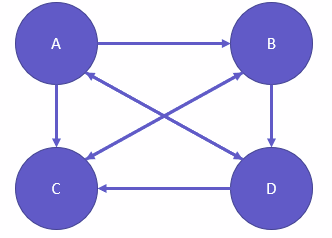

Generate a web system as an RDD of pair tuples (page name, neighbor page name) from a pair rdd (page name, list of all neighbors)
Hint: check out for pair rdd opearations such as, `mapValues` or `flatMapValues`. [Spark reference](https://spark.apache.org/docs/2.2.0/api/python/pyspark.html#pyspark.RDD)

In [55]:
def map_websystem_rdd(sc: SparkContext, neighbor_rdd: RDD) -> RDD:
    """
    This function gets input web system as rdd and mapping rdd of the system.
    And returns the mapping of the connection between each two web pages
    input:
        sc: spark context
        neighbor_rdd: a pair RDD of the web system contain each web and its links (web page, list of neighbor pages)
    output:
        return a pair RDD that contain all links (web page, neighbor web page)
    """
    web_system_rdd = neighbor_rdd.flatMapValues(lambda x: x)
    return web_system_rdd

In [56]:
neighbor_rdd = sc.parallelize([
                ('a', ['b','c','d']),
                ('c', ['b']), 
                ('b', ['c','d']), 
                ('d', ['a','c'])
              ])

In [57]:
result = map_websystem_rdd(sc, neighbor_rdd).collect()

In [58]:
assert result == [
                    ('a', 'b'), ('a', 'c'), ('a', 'd'), 
                    ('c', 'b'), 
                    ('b', 'c'), ('b', 'd'), 
                    ('d', 'a'), ('d', 'c')
                ]

23/01/01 00:41:05 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1062814 ms exceeds timeout 120000 ms
23/01/01 00:41:05 WARN SparkContext: Killing executors is not supported by current scheduler.


## Kaggle dataset analysis

You can choose whatever data set you like from Kaggle and you need to derive meanigful insights using the Pyspark Dataframe API.
You need to use at least once from the following [DataFrame API](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.html#pyspark.sql.DataFrame):

*   [show](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.show.html#pyspark.sql.DataFrame.show)
*   [printSchema](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.printSchema.html#pyspark.sql.DataFrame.printSchema)
*   [distinct](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.distinct.html#pyspark.sql.DataFrame.distinct)
*   [filter](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.filter.html#pyspark.sql.DataFrame.filter)
*   [foreach](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.foreach.html#pyspark.sql.DataFrame.foreach)
*   [join](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.join.html#pyspark.sql.DataFrame.join)
*   [orderBy](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.orderBy.html#pyspark.sql.DataFrame.orderBy)
*   [sample](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.sample.html#pyspark.sql.DataFrame.sample)
*   [select](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.select.html#pyspark.sql.DataFrame.select)
*   [subtract](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.subtract.html#pyspark.sql.DataFrame.subtract)
*   [where](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.where.html#pyspark.sql.DataFrame.where)
*   [withColumn](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html#pyspark.sql.DataFrame.withColumn)
*   [withColumnRenamed](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.withColumnRenamed.html#pyspark.sql.DataFrame.withColumnRenamed)

In addition use at least once of the following [functions](https://spark.apache.org/docs/3.1.1/api/python/reference/pyspark.sql.html#functions):
*   [array_contains](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.array_contains.html#pyspark.sql.functions.array_contains)
*   [avg](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.avg.html#pyspark.sql.functions.avg)
*   [collect_set](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.collect_set.html#pyspark.sql.functions.collect_set)
*   [countDistinct](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.countDistinct.html#pyspark.sql.functions.countDistinct)
*   [datediff](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.datediff.html#pyspark.sql.functions.datediff)
*   [min](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.min.html#pyspark.sql.functions.min)
*   [regexp_extract](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.regexp_extract.html#pyspark.sql.functions.regexp_extract)
*   [window](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.window.html?highlight=window)





# Close spark session

In [ ]:
sc.stop()